In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(701992, 828)
(701992, 1)
validation
(107232, 828)
(107232, 1)
test
(76096, 828)
(76096, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/71 [..............................] - ETA: 1:29 - loss: 0.0355 - STD: 1.7087e-04 - MAE: 0.1704

 4/71 [>.............................] - ETA: 1s - loss: 0.0229 - STD: 2.5742e-04 - MAE: 0.1194  

 5/71 [=>............................] - ETA: 2s - loss: 0.0235 - STD: 2.4752e-04 - MAE: 0.1205

 6/71 [=>............................] - ETA: 2s - loss: 0.0235 - STD: 2.4102e-04 - MAE: 0.1201

 7/71 [=>............................] - ETA: 3s - loss: 0.0230 - STD: 2.3890e-04 - MAE: 0.1180

 8/71 [==>...........................] - ETA: 3s - loss: 0.0222 - STD: 2.4128e-04 - MAE: 0.1149

 9/71 [==>...........................] - ETA: 3s - loss: 0.0212 - STD: 2.4819e-04 - MAE: 0.1112

10/71 [===>..........................] - ETA: 3s - loss: 0.0201 - STD: 2.5881e-04 - MAE: 0.1079

11/71 [===>..........................] - ETA: 5s - loss: 0.0199 - STD: 2.7339e-04 - MAE: 0.1059

15/71 [=====>........................] - ETA: 4s - loss: 0.0183 - STD: 3.3680e-04 - MAE: 0.1047

16/71 [=====>........................] - ETA: 4s - loss: 0.0178 - STD: 3.5014e-04 - MAE: 0.1038

17/71 [======>.......................] - ETA: 4s - loss: 0.0174 - STD: 3.6199e-04 - MAE: 0.1025

18/71 [======>.......................] - ETA: 4s - loss: 0.0170 - STD: 3.7174e-04 - MAE: 0.1012

19/71 [=======>......................] - ETA: 3s - loss: 0.0167 - STD: 3.7989e-04 - MAE: 0.1000

20/71 [=======>......................] - ETA: 3s - loss: 0.0164 - STD: 3.8730e-04 - MAE: 0.0989

21/71 [=======>......................] - ETA: 3s - loss: 0.0162 - STD: 3.9429e-04 - MAE: 0.0980

22/71 [========>.....................] - ETA: 3s - loss: 0.0160 - STD: 4.0131e-04 - MAE: 0.0971

23/71 [========>.....................] - ETA: 3s - loss: 0.0158 - STD: 4.0881e-04 - MAE: 0.0964

24/71 [=========>....................] - ETA: 3s - loss: 0.0157 - STD: 4.1721e-04 - MAE: 0.0957

25/71 [=========>....................] - ETA: 3s - loss: 0.0155 - STD: 4.2693e-04 - MAE: 0.0950

26/71 [=========>....................] - ETA: 3s - loss: 0.0153 - STD: 4.3833e-04 - MAE: 0.0943

27/71 [==========>...................] - ETA: 3s - loss: 0.0151 - STD: 4.5041e-04 - MAE: 0.0938

28/71 [==========>...................] - ETA: 3s - loss: 0.0149 - STD: 4.6394e-04 - MAE: 0.0934

29/71 [===========>..................] - ETA: 3s - loss: 0.0148 - STD: 4.7810e-04 - MAE: 0.0931

30/71 [===========>..................] - ETA: 2s - loss: 0.0147 - STD: 4.9307e-04 - MAE: 0.0929

31/71 [============>.................] - ETA: 2s - loss: 0.0146 - STD: 5.0858e-04 - MAE: 0.0927

32/71 [============>.................] - ETA: 2s - loss: 0.0145 - STD: 5.2389e-04 - MAE: 0.0925

33/71 [============>.................] - ETA: 2s - loss: 0.0143 - STD: 5.3899e-04 - MAE: 0.0923

34/71 [=============>................] - ETA: 2s - loss: 0.0142 - STD: 5.5347e-04 - MAE: 0.0920

35/71 [=============>................] - ETA: 2s - loss: 0.0141 - STD: 5.6757e-04 - MAE: 0.0917

36/71 [==============>...............] - ETA: 2s - loss: 0.0140 - STD: 5.8114e-04 - MAE: 0.0913

37/71 [==============>...............] - ETA: 2s - loss: 0.0139 - STD: 5.9440e-04 - MAE: 0.0910

38/71 [===============>..............] - ETA: 2s - loss: 0.0138 - STD: 6.0764e-04 - MAE: 0.0906

39/71 [===============>..............] - ETA: 2s - loss: 0.0138 - STD: 6.2122e-04 - MAE: 0.0903

40/71 [===============>..............] - ETA: 2s - loss: 0.0137 - STD: 6.3534e-04 - MAE: 0.0900

41/71 [================>.............] - ETA: 2s - loss: 0.0136 - STD: 6.5032e-04 - MAE: 0.0897

42/71 [================>.............] - ETA: 2s - loss: 0.0135 - STD: 6.6666e-04 - MAE: 0.0894

43/71 [=================>............] - ETA: 1s - loss: 0.0135 - STD: 6.8428e-04 - MAE: 0.0892

44/71 [=================>............] - ETA: 1s - loss: 0.0134 - STD: 7.0303e-04 - MAE: 0.0890

45/71 [==================>...........] - ETA: 1s - loss: 0.0133 - STD: 7.2269e-04 - MAE: 0.0888

46/71 [==================>...........] - ETA: 1s - loss: 0.0133 - STD: 7.4369e-04 - MAE: 0.0886

47/71 [==================>...........] - ETA: 1s - loss: 0.0132 - STD: 7.6563e-04 - MAE: 0.0885

48/71 [===================>..........] - ETA: 1s - loss: 0.0132 - STD: 7.8839e-04 - MAE: 0.0884

49/71 [===================>..........] - ETA: 1s - loss: 0.0131 - STD: 8.1213e-04 - MAE: 0.0882

50/71 [====================>.........] - ETA: 1s - loss: 0.0130 - STD: 8.3688e-04 - MAE: 0.0881

51/71 [====================>.........] - ETA: 1s - loss: 0.0130 - STD: 8.6198e-04 - MAE: 0.0880

52/71 [====================>.........] - ETA: 1s - loss: 0.0129 - STD: 8.8728e-04 - MAE: 0.0878

53/71 [=====================>........] - ETA: 1s - loss: 0.0129 - STD: 9.1345e-04 - MAE: 0.0876

54/71 [=====================>........] - ETA: 1s - loss: 0.0128 - STD: 9.3990e-04 - MAE: 0.0874

55/71 [======================>.......] - ETA: 1s - loss: 0.0128 - STD: 9.6795e-04 - MAE: 0.0873

56/71 [======================>.......] - ETA: 1s - loss: 0.0127 - STD: 9.9706e-04 - MAE: 0.0871

57/71 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 0.0010 - MAE: 0.0869    

58/71 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 0.0011 - MAE: 0.0868

59/71 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 0.0011 - MAE: 0.0867

60/71 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 0.0011 - MAE: 0.0865

61/71 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0864

62/71 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0863

63/71 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0862

64/71 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 0.0013 - MAE: 0.0861

65/71 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 0.0014 - MAE: 0.0860

66/71 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 0.0014 - MAE: 0.0859

67/71 [===========================>..] - ETA: 0s - loss: 0.0123 - STD: 0.0015 - MAE: 0.0858

68/71 [===========================>..] - ETA: 0s - loss: 0.0123 - STD: 0.0015 - MAE: 0.0857

69/71 [============================>.] - ETA: 0s - loss: 0.0123 - STD: 0.0016 - MAE: 0.0856

70/71 [============================>.] - ETA: 0s - loss: 0.0122 - STD: 0.0017 - MAE: 0.0855

71/71 [==============================] - ETA: 0s - loss: 0.0122 - STD: 0.0017 - MAE: 0.0854

71/71 [==============================] - 7s 79ms/step - loss: 0.0122 - STD: 0.0017 - MAE: 0.0854 - val_loss: 0.0109 - val_STD: 0.0065 - val_MAE: 0.0796


Epoch 2/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0097 - STD: 0.0071 - MAE: 0.0770

 2/71 [..............................] - ETA: 5s - loss: 0.0098 - STD: 0.0074 - MAE: 0.0776

 3/71 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 0.0077 - MAE: 0.0778

 4/71 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 0.0080 - MAE: 0.0777

 5/71 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 0.0084 - MAE: 0.0778

 6/71 [=>............................] - ETA: 4s - loss: 0.0097 - STD: 0.0087 - MAE: 0.0778

 7/71 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 0.0091 - MAE: 0.0780

 8/71 [==>...........................] - ETA: 4s - loss: 0.0098 - STD: 0.0095 - MAE: 0.0780

 9/71 [==>...........................] - ETA: 4s - loss: 0.0098 - STD: 0.0099 - MAE: 0.0779

10/71 [===>..........................] - ETA: 4s - loss: 0.0097 - STD: 0.0103 - MAE: 0.0778

11/71 [===>..........................] - ETA: 4s - loss: 0.0097 - STD: 0.0107 - MAE: 0.0776

12/71 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 0.0112 - MAE: 0.0775

13/71 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 0.0116 - MAE: 0.0773

14/71 [====>.........................] - ETA: 3s - loss: 0.0096 - STD: 0.0122 - MAE: 0.0771

15/71 [=====>........................] - ETA: 3s - loss: 0.0095 - STD: 0.0127 - MAE: 0.0770

16/71 [=====>........................] - ETA: 3s - loss: 0.0095 - STD: 0.0133 - MAE: 0.0768

17/71 [======>.......................] - ETA: 3s - loss: 0.0094 - STD: 0.0140 - MAE: 0.0767

18/71 [======>.......................] - ETA: 3s - loss: 0.0094 - STD: 0.0146 - MAE: 0.0765

19/71 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 0.0153 - MAE: 0.0764

20/71 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 0.0160 - MAE: 0.0763

21/71 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 0.0167 - MAE: 0.0761

22/71 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 0.0174 - MAE: 0.0759

23/71 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 0.0182 - MAE: 0.0758

24/71 [=========>....................] - ETA: 3s - loss: 0.0091 - STD: 0.0190 - MAE: 0.0756

25/71 [=========>....................] - ETA: 3s - loss: 0.0091 - STD: 0.0198 - MAE: 0.0754

26/71 [=========>....................] - ETA: 3s - loss: 0.0091 - STD: 0.0206 - MAE: 0.0753

27/71 [==========>...................] - ETA: 3s - loss: 0.0090 - STD: 0.0214 - MAE: 0.0751

28/71 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.0222 - MAE: 0.0750

29/71 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0230 - MAE: 0.0748

30/71 [===========>..................] - ETA: 2s - loss: 0.0089 - STD: 0.0238 - MAE: 0.0747

31/71 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.0245 - MAE: 0.0746

32/71 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.0253 - MAE: 0.0745

34/71 [=============>................] - ETA: 2s - loss: 0.0089 - STD: 0.0267 - MAE: 0.0743

35/71 [=============>................] - ETA: 2s - loss: 0.0088 - STD: 0.0273 - MAE: 0.0741

36/71 [==============>...............] - ETA: 2s - loss: 0.0088 - STD: 0.0280 - MAE: 0.0740

37/71 [==============>...............] - ETA: 2s - loss: 0.0088 - STD: 0.0286 - MAE: 0.0739

38/71 [===============>..............] - ETA: 2s - loss: 0.0088 - STD: 0.0291 - MAE: 0.0738

39/71 [===============>..............] - ETA: 2s - loss: 0.0087 - STD: 0.0297 - MAE: 0.0737

40/71 [===============>..............] - ETA: 2s - loss: 0.0087 - STD: 0.0302 - MAE: 0.0736

41/71 [================>.............] - ETA: 2s - loss: 0.0087 - STD: 0.0306 - MAE: 0.0734

42/71 [================>.............] - ETA: 1s - loss: 0.0087 - STD: 0.0311 - MAE: 0.0733

43/71 [=================>............] - ETA: 1s - loss: 0.0087 - STD: 0.0315 - MAE: 0.0732

44/71 [=================>............] - ETA: 1s - loss: 0.0086 - STD: 0.0319 - MAE: 0.0731

45/71 [==================>...........] - ETA: 1s - loss: 0.0086 - STD: 0.0322 - MAE: 0.0730

46/71 [==================>...........] - ETA: 1s - loss: 0.0086 - STD: 0.0326 - MAE: 0.0729

47/71 [==================>...........] - ETA: 1s - loss: 0.0086 - STD: 0.0329 - MAE: 0.0729

48/71 [===================>..........] - ETA: 1s - loss: 0.0086 - STD: 0.0332 - MAE: 0.0727

49/71 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.0335 - MAE: 0.0727

50/71 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.0338 - MAE: 0.0726

51/71 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.0341 - MAE: 0.0725

52/71 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.0344 - MAE: 0.0724

53/71 [=====================>........] - ETA: 1s - loss: 0.0085 - STD: 0.0347 - MAE: 0.0723

54/71 [=====================>........] - ETA: 1s - loss: 0.0085 - STD: 0.0349 - MAE: 0.0722

55/71 [======================>.......] - ETA: 1s - loss: 0.0084 - STD: 0.0352 - MAE: 0.0722

56/71 [======================>.......] - ETA: 1s - loss: 0.0084 - STD: 0.0355 - MAE: 0.0721

57/71 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.0357 - MAE: 0.0720

58/71 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.0360 - MAE: 0.0719

59/71 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.0363 - MAE: 0.0718

60/71 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0366 - MAE: 0.0718

61/71 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0368 - MAE: 0.0717

62/71 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0371 - MAE: 0.0716

63/71 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0373 - MAE: 0.0715

64/71 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0375 - MAE: 0.0715

65/71 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0378 - MAE: 0.0714

66/71 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0380 - MAE: 0.0713

67/71 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.0382 - MAE: 0.0713

68/71 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.0384 - MAE: 0.0712

69/71 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.0386 - MAE: 0.0711

70/71 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.0388 - MAE: 0.0711

71/71 [==============================] - ETA: 0s - loss: 0.0082 - STD: 0.0390 - MAE: 0.0710

71/71 [==============================] - 5s 71ms/step - loss: 0.0082 - STD: 0.0390 - MAE: 0.0710 - val_loss: 0.0080 - val_STD: 0.0475 - val_MAE: 0.0674


Epoch 3/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0073 - STD: 0.0530 - MAE: 0.0664

 2/71 [..............................] - ETA: 4s - loss: 0.0073 - STD: 0.0530 - MAE: 0.0662

 3/71 [>.............................] - ETA: 4s - loss: 0.0073 - STD: 0.0529 - MAE: 0.0662

 4/71 [>.............................] - ETA: 4s - loss: 0.0073 - STD: 0.0527 - MAE: 0.0660

 5/71 [=>............................] - ETA: 4s - loss: 0.0072 - STD: 0.0525 - MAE: 0.0658

 6/71 [=>............................] - ETA: 4s - loss: 0.0072 - STD: 0.0526 - MAE: 0.0658

 7/71 [=>............................] - ETA: 4s - loss: 0.0072 - STD: 0.0527 - MAE: 0.0657

 8/71 [==>...........................] - ETA: 4s - loss: 0.0072 - STD: 0.0527 - MAE: 0.0656

 9/71 [==>...........................] - ETA: 4s - loss: 0.0071 - STD: 0.0528 - MAE: 0.0653

10/71 [===>..........................] - ETA: 4s - loss: 0.0071 - STD: 0.0528 - MAE: 0.0652

11/71 [===>..........................] - ETA: 3s - loss: 0.0071 - STD: 0.0529 - MAE: 0.0652

12/71 [====>.........................] - ETA: 3s - loss: 0.0071 - STD: 0.0530 - MAE: 0.0650

13/71 [====>.........................] - ETA: 3s - loss: 0.0070 - STD: 0.0532 - MAE: 0.0649

14/71 [====>.........................] - ETA: 3s - loss: 0.0070 - STD: 0.0534 - MAE: 0.0648

15/71 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.0535 - MAE: 0.0646

16/71 [=====>........................] - ETA: 3s - loss: 0.0069 - STD: 0.0536 - MAE: 0.0645

17/71 [======>.......................] - ETA: 3s - loss: 0.0069 - STD: 0.0538 - MAE: 0.0645

18/71 [======>.......................] - ETA: 3s - loss: 0.0069 - STD: 0.0541 - MAE: 0.0644

19/71 [=======>......................] - ETA: 3s - loss: 0.0069 - STD: 0.0543 - MAE: 0.0644

20/71 [=======>......................] - ETA: 3s - loss: 0.0069 - STD: 0.0544 - MAE: 0.0642

21/71 [=======>......................] - ETA: 3s - loss: 0.0069 - STD: 0.0546 - MAE: 0.0641

22/71 [========>.....................] - ETA: 3s - loss: 0.0068 - STD: 0.0549 - MAE: 0.0640

23/71 [========>.....................] - ETA: 3s - loss: 0.0068 - STD: 0.0551 - MAE: 0.0639

24/71 [=========>....................] - ETA: 3s - loss: 0.0068 - STD: 0.0553 - MAE: 0.0638

26/71 [=========>....................] - ETA: 2s - loss: 0.0068 - STD: 0.0557 - MAE: 0.0636

27/71 [==========>...................] - ETA: 2s - loss: 0.0068 - STD: 0.0560 - MAE: 0.0635

28/71 [==========>...................] - ETA: 2s - loss: 0.0068 - STD: 0.0562 - MAE: 0.0634

29/71 [===========>..................] - ETA: 2s - loss: 0.0067 - STD: 0.0565 - MAE: 0.0633

30/71 [===========>..................] - ETA: 2s - loss: 0.0067 - STD: 0.0566 - MAE: 0.0632

31/71 [============>.................] - ETA: 2s - loss: 0.0067 - STD: 0.0570 - MAE: 0.0631

32/71 [============>.................] - ETA: 2s - loss: 0.0067 - STD: 0.0571 - MAE: 0.0630

33/71 [============>.................] - ETA: 2s - loss: 0.0067 - STD: 0.0575 - MAE: 0.0629

34/71 [=============>................] - ETA: 2s - loss: 0.0067 - STD: 0.0577 - MAE: 0.0628

35/71 [=============>................] - ETA: 2s - loss: 0.0066 - STD: 0.0578 - MAE: 0.0627

36/71 [==============>...............] - ETA: 2s - loss: 0.0066 - STD: 0.0582 - MAE: 0.0627

37/71 [==============>...............] - ETA: 2s - loss: 0.0066 - STD: 0.0582 - MAE: 0.0626

38/71 [===============>..............] - ETA: 2s - loss: 0.0066 - STD: 0.0585 - MAE: 0.0625

39/71 [===============>..............] - ETA: 2s - loss: 0.0066 - STD: 0.0587 - MAE: 0.0625

40/71 [===============>..............] - ETA: 2s - loss: 0.0066 - STD: 0.0588 - MAE: 0.0623

41/71 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0590 - MAE: 0.0623

42/71 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0592 - MAE: 0.0622

43/71 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.0593 - MAE: 0.0621

44/71 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.0595 - MAE: 0.0621

45/71 [==================>...........] - ETA: 1s - loss: 0.0065 - STD: 0.0596 - MAE: 0.0620

46/71 [==================>...........] - ETA: 1s - loss: 0.0065 - STD: 0.0597 - MAE: 0.0620

47/71 [==================>...........] - ETA: 1s - loss: 0.0065 - STD: 0.0599 - MAE: 0.0619

48/71 [===================>..........] - ETA: 1s - loss: 0.0065 - STD: 0.0600 - MAE: 0.0619

49/71 [===================>..........] - ETA: 1s - loss: 0.0065 - STD: 0.0601 - MAE: 0.0618

50/71 [====================>.........] - ETA: 1s - loss: 0.0065 - STD: 0.0603 - MAE: 0.0617

51/71 [====================>.........] - ETA: 1s - loss: 0.0065 - STD: 0.0603 - MAE: 0.0617

52/71 [====================>.........] - ETA: 1s - loss: 0.0064 - STD: 0.0605 - MAE: 0.0616

53/71 [=====================>........] - ETA: 1s - loss: 0.0064 - STD: 0.0606 - MAE: 0.0615

54/71 [=====================>........] - ETA: 1s - loss: 0.0064 - STD: 0.0606 - MAE: 0.0615

55/71 [======================>.......] - ETA: 1s - loss: 0.0064 - STD: 0.0608 - MAE: 0.0614

56/71 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0608 - MAE: 0.0613

57/71 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0609 - MAE: 0.0613

58/71 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0610 - MAE: 0.0612

59/71 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0611 - MAE: 0.0612

60/71 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0612 - MAE: 0.0611

61/71 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0613 - MAE: 0.0610

62/71 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0613 - MAE: 0.0610

63/71 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0614 - MAE: 0.0609

64/71 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0615 - MAE: 0.0609

65/71 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0616 - MAE: 0.0608

66/71 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0617 - MAE: 0.0608

67/71 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0618 - MAE: 0.0607

68/71 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0619 - MAE: 0.0606

69/71 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0620 - MAE: 0.0606

70/71 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0621 - MAE: 0.0605

71/71 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0621 - MAE: 0.0604

71/71 [==============================] - 5s 70ms/step - loss: 0.0062 - STD: 0.0621 - MAE: 0.0604 - val_loss: 0.0058 - val_STD: 0.0691 - val_MAE: 0.0579


Epoch 4/10000


 1/71 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0584

 2/71 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0691 - MAE: 0.0571

 3/71 [>.............................] - ETA: 5s - loss: 0.0056 - STD: 0.0701 - MAE: 0.0573

 4/71 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0693 - MAE: 0.0569

 5/71 [=>............................] - ETA: 4s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0569

 6/71 [=>............................] - ETA: 4s - loss: 0.0056 - STD: 0.0696 - MAE: 0.0571

 7/71 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.0682 - MAE: 0.0570

 8/71 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.0689 - MAE: 0.0574

 9/71 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.0685 - MAE: 0.0572

10/71 [===>..........................] - ETA: 4s - loss: 0.0057 - STD: 0.0680 - MAE: 0.0570

11/71 [===>..........................] - ETA: 4s - loss: 0.0056 - STD: 0.0685 - MAE: 0.0572

12/71 [====>.........................] - ETA: 4s - loss: 0.0057 - STD: 0.0679 - MAE: 0.0570

13/71 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.0680 - MAE: 0.0569

14/71 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0684 - MAE: 0.0571

15/71 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0571

16/71 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0681 - MAE: 0.0571

17/71 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0683 - MAE: 0.0572

18/71 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0679 - MAE: 0.0570

19/71 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0680 - MAE: 0.0570

20/71 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0684 - MAE: 0.0572

21/71 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0572

22/71 [========>.....................] - ETA: 3s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0571

23/71 [========>.....................] - ETA: 3s - loss: 0.0058 - STD: 0.0683 - MAE: 0.0576

24/71 [=========>....................] - ETA: 3s - loss: 0.0058 - STD: 0.0678 - MAE: 0.0575

25/71 [=========>....................] - ETA: 3s - loss: 0.0058 - STD: 0.0673 - MAE: 0.0575

26/71 [=========>....................] - ETA: 3s - loss: 0.0058 - STD: 0.0677 - MAE: 0.0578

27/71 [==========>...................] - ETA: 3s - loss: 0.0058 - STD: 0.0677 - MAE: 0.0578

28/71 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0673 - MAE: 0.0577

29/71 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0671 - MAE: 0.0576

30/71 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0673 - MAE: 0.0577

31/71 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0672 - MAE: 0.0577

32/71 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0669 - MAE: 0.0577

33/71 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0668 - MAE: 0.0576

34/71 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0669 - MAE: 0.0576

35/71 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0669 - MAE: 0.0576

36/71 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0668 - MAE: 0.0575

37/71 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0574

38/71 [===============>..............] - ETA: 2s - loss: 0.0058 - STD: 0.0669 - MAE: 0.0575

39/71 [===============>..............] - ETA: 2s - loss: 0.0058 - STD: 0.0669 - MAE: 0.0575

40/71 [===============>..............] - ETA: 2s - loss: 0.0057 - STD: 0.0669 - MAE: 0.0574

41/71 [================>.............] - ETA: 2s - loss: 0.0057 - STD: 0.0669 - MAE: 0.0573

42/71 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0573

43/71 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0573

44/71 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0572

45/71 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0572

46/71 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0572

47/71 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0571

48/71 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0571

49/71 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0673 - MAE: 0.0570

50/71 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0674 - MAE: 0.0570

51/71 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0569

52/71 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0569

53/71 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0675 - MAE: 0.0568

54/71 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0676 - MAE: 0.0568

55/71 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0677 - MAE: 0.0568

56/71 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0677 - MAE: 0.0568

57/71 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0678 - MAE: 0.0567

58/71 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0679 - MAE: 0.0567

59/71 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0679 - MAE: 0.0567

60/71 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0679 - MAE: 0.0567

61/71 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0680 - MAE: 0.0566

62/71 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0680 - MAE: 0.0566

63/71 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0681 - MAE: 0.0565

64/71 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0682 - MAE: 0.0565

65/71 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0682 - MAE: 0.0565

66/71 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0683 - MAE: 0.0565

67/71 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0684 - MAE: 0.0565

68/71 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0684 - MAE: 0.0564

69/71 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0685 - MAE: 0.0564

70/71 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0686 - MAE: 0.0564

71/71 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0686 - MAE: 0.0563

71/71 [==============================] - 5s 72ms/step - loss: 0.0056 - STD: 0.0686 - MAE: 0.0563 - val_loss: 0.0057 - val_STD: 0.0681 - val_MAE: 0.0549


Epoch 5/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0052 - STD: 0.0694 - MAE: 0.0528

 2/71 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0722 - MAE: 0.0539

 3/71 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0719 - MAE: 0.0536

 4/71 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0716 - MAE: 0.0537

 5/71 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0723 - MAE: 0.0540

 6/71 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0720 - MAE: 0.0540

 7/71 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0717 - MAE: 0.0538

 8/71 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0719 - MAE: 0.0540

 9/71 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0719 - MAE: 0.0539

10/71 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0716 - MAE: 0.0538

11/71 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0718 - MAE: 0.0539

12/71 [====>.........................] - ETA: 4s - loss: 0.0051 - STD: 0.0718 - MAE: 0.0537

13/71 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0718 - MAE: 0.0537

14/71 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0718 - MAE: 0.0537

15/71 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0718 - MAE: 0.0537

16/71 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0719 - MAE: 0.0537

17/71 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0719 - MAE: 0.0537

18/71 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0718 - MAE: 0.0536

19/71 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0720 - MAE: 0.0537

20/71 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0719 - MAE: 0.0536

21/71 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0718 - MAE: 0.0536

22/71 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0722 - MAE: 0.0538

23/71 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0538

24/71 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0720 - MAE: 0.0538

25/71 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0722 - MAE: 0.0539

27/71 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0540

28/71 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0722 - MAE: 0.0539

29/71 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0539

30/71 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0540

31/71 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0540

32/71 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0539

33/71 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0541

34/71 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0541

35/71 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0540

36/71 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0544

37/71 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0545

38/71 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0544

39/71 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0717 - MAE: 0.0549

40/71 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0714 - MAE: 0.0549

41/71 [================>.............] - ETA: 2s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0549

42/71 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0550

43/71 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0552

44/71 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0551

45/71 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0551

46/71 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0552

47/71 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0553

48/71 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0553

49/71 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0553

50/71 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0553

51/71 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0554

52/71 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0554

53/71 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0701 - MAE: 0.0554

54/71 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0553

55/71 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0701 - MAE: 0.0554

56/71 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0701 - MAE: 0.0554

57/71 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0554

58/71 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0699 - MAE: 0.0553

59/71 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0554

60/71 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0554

61/71 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0699 - MAE: 0.0553

62/71 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0698 - MAE: 0.0553

63/71 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0699 - MAE: 0.0553

64/71 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0553

65/71 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0699 - MAE: 0.0553

66/71 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0699 - MAE: 0.0552

67/71 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0699 - MAE: 0.0552

68/71 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0552

69/71 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0552

70/71 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0552

71/71 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0551

71/71 [==============================] - 5s 71ms/step - loss: 0.0054 - STD: 0.0700 - MAE: 0.0551 - val_loss: 0.0053 - val_STD: 0.0742 - val_MAE: 0.0549


Epoch 6/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0545

 2/71 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0743 - MAE: 0.0541

 3/71 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0731 - MAE: 0.0535

 4/71 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0534

 5/71 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0741 - MAE: 0.0535

 6/71 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0532

 7/71 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0531

 8/71 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0531

 9/71 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0531

10/71 [===>..........................] - ETA: 4s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0530

11/71 [===>..........................] - ETA: 4s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0531

12/71 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0531

13/71 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0529

14/71 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0529

15/71 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0530

16/71 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0530

17/71 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0529

18/71 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0528

19/71 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0528

21/71 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0529

22/71 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0528

23/71 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0528

24/71 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0528

25/71 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0528

26/71 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0528

27/71 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0528

28/71 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0528

29/71 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0527

30/71 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0527

31/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0527

32/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0527

33/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0527

34/71 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0527

35/71 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0526

36/71 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0526

37/71 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0526

38/71 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0526

39/71 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0525

40/71 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0525

41/71 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0525

42/71 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0525

43/71 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0525

44/71 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0525

45/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0524

46/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0525

47/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0525

48/71 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0524

49/71 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524

50/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

51/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524

52/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524

53/71 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

54/71 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524

55/71 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0523

56/71 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

57/71 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0523

58/71 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0523

59/71 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0523

60/71 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0523

61/71 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0523

62/71 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0523

63/71 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0523

64/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0523

65/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0523

66/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0523

67/71 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0522

68/71 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0522

69/71 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0522

70/71 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0522

71/71 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0522

71/71 [==============================] - 5s 64ms/step - loss: 0.0049 - STD: 0.0744 - MAE: 0.0522 - val_loss: 0.0052 - val_STD: 0.0731 - val_MAE: 0.0528


Epoch 7/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0739 - MAE: 0.0506

 2/71 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0511

 3/71 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0511

 4/71 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

 5/71 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

 6/71 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0512

 7/71 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

 8/71 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0512

 9/71 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0752 - MAE: 0.0512

10/71 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0512

11/71 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0752 - MAE: 0.0512

12/71 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0512

13/71 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0512

14/71 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0512

15/71 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0512

16/71 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0512

17/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0757 - MAE: 0.0513

18/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0513

19/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0513

20/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0757 - MAE: 0.0515

21/71 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0515

22/71 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0515

23/71 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0515

24/71 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0516

25/71 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0518

26/71 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

27/71 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0517

28/71 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0519

29/71 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0519

30/71 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0519

31/71 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0520

32/71 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0521

33/71 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0521

34/71 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0524

35/71 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0745 - MAE: 0.0526

36/71 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

37/71 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0746 - MAE: 0.0532

38/71 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0742 - MAE: 0.0533

39/71 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0736 - MAE: 0.0535

40/71 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0737 - MAE: 0.0536

41/71 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0738 - MAE: 0.0538

42/71 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0734 - MAE: 0.0538

43/71 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0730 - MAE: 0.0538

44/71 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0539

45/71 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0730 - MAE: 0.0541

46/71 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0727 - MAE: 0.0541

47/71 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0723 - MAE: 0.0541

48/71 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0722 - MAE: 0.0541

49/71 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0723 - MAE: 0.0542

50/71 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0722 - MAE: 0.0542

51/71 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0720 - MAE: 0.0542

52/71 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0542

53/71 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0542

54/71 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0543

55/71 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0542

57/71 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0542

58/71 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0543

59/71 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0542

60/71 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0542

61/71 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0541

62/71 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0715 - MAE: 0.0542

63/71 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0542

64/71 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0541

65/71 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0715 - MAE: 0.0541

66/71 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0540

67/71 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0540

68/71 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0540

69/71 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0539

70/71 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0539

71/71 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0539

71/71 [==============================] - 4s 62ms/step - loss: 0.0052 - STD: 0.0718 - MAE: 0.0539 - val_loss: 0.0052 - val_STD: 0.0731 - val_MAE: 0.0527


Epoch 8/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0738 - MAE: 0.0517

 2/71 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0723 - MAE: 0.0511

 3/71 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0731 - MAE: 0.0512

 4/71 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0516

 5/71 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0514

 6/71 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0512

 7/71 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0745 - MAE: 0.0513

 8/71 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0516

 9/71 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0514

10/71 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0514

11/71 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0514

12/71 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0516

13/71 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0515

14/71 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0514

15/71 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0515

16/71 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0515

17/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0514

18/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0514

19/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0514

20/71 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0750 - MAE: 0.0514

21/71 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0513

22/71 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0748 - MAE: 0.0513

23/71 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0513

24/71 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0750 - MAE: 0.0514

25/71 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0513

26/71 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0748 - MAE: 0.0513

27/71 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0513

28/71 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0750 - MAE: 0.0513

29/71 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0512

30/71 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0512

31/71 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0750 - MAE: 0.0512

32/71 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0512

33/71 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0750 - MAE: 0.0512

34/71 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0750 - MAE: 0.0511

35/71 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0511

36/71 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0511

37/71 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0511

38/71 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0752 - MAE: 0.0511

39/71 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0752 - MAE: 0.0511

40/71 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0752 - MAE: 0.0510

41/71 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0510

42/71 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0510

43/71 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0510

44/71 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0510

45/71 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0510

46/71 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0510

47/71 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0510

48/71 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0509

49/71 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0509

50/71 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0509

51/71 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0509

52/71 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0509

53/71 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0508

54/71 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0508

55/71 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0508

56/71 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0508

57/71 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0508

58/71 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0508

59/71 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0508

61/71 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0508

62/71 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0507

63/71 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0507

64/71 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0757 - MAE: 0.0507

65/71 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0757 - MAE: 0.0507

66/71 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0507

67/71 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0507

68/71 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0507

69/71 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0759 - MAE: 0.0507

70/71 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0759 - MAE: 0.0507

71/71 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0759 - MAE: 0.0507

71/71 [==============================] - 4s 62ms/step - loss: 0.0046 - STD: 0.0759 - MAE: 0.0507 - val_loss: 0.0050 - val_STD: 0.0781 - val_MAE: 0.0523


Epoch 9/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0787 - MAE: 0.0501

 2/71 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0497

 3/71 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0497

 4/71 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0500

 5/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0500

 6/71 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0499

 7/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0501

 8/71 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0499

 9/71 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0500

10/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0500

11/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0500

12/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

13/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

14/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

15/71 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

16/71 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

17/71 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

18/71 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

19/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

20/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

21/71 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0498

22/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

23/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

24/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

25/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

26/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

27/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

28/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

29/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

30/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

31/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

32/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0497

33/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

34/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0497

35/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

36/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

37/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0497

38/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

39/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

40/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

41/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

42/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

44/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

45/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

46/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

47/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

48/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

49/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

50/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

51/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

52/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

53/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

54/71 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

55/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

56/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

57/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

58/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

59/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

60/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

61/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

62/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

63/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

64/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

65/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

66/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

67/71 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

68/71 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

69/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0497

70/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

71/71 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

71/71 [==============================] - 4s 62ms/step - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497 - val_loss: 0.0050 - val_STD: 0.0780 - val_MAE: 0.0518


Epoch 10/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

 3/71 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0494

 4/71 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0788 - MAE: 0.0494

 5/71 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0493

 6/71 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0493

 7/71 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0493

 8/71 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0493

 9/71 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

10/71 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0492

11/71 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0491

12/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0491

13/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

14/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0490

15/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

16/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

17/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

18/71 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

19/71 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0493

20/71 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0493

21/71 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0780 - MAE: 0.0496

22/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

23/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

24/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

25/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

26/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

27/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

28/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

29/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

30/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

31/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

32/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

33/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

34/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

35/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

36/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

37/71 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

38/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

39/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

40/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0497

41/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

42/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

43/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

44/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

45/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

46/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

47/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

48/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

49/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

50/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

51/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

52/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

53/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

54/71 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

55/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

56/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

57/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

58/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

59/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

60/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

61/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

62/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

63/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

64/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0497

65/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

66/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

67/71 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

68/71 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

69/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0497

70/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

71/71 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

71/71 [==============================] - 4s 62ms/step - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497 - val_loss: 0.0051 - val_STD: 0.0746 - val_MAE: 0.0513


Epoch 11/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0480

 2/71 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0774 - MAE: 0.0488

 3/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0771 - MAE: 0.0488

 4/71 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0769 - MAE: 0.0488

 5/71 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

 6/71 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0774 - MAE: 0.0490

 7/71 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0490

 8/71 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0490

 9/71 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0489

10/71 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0490

11/71 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0489

12/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0489

13/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0489

14/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0489

15/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0489

16/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0488

17/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0488

18/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0488

19/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

20/71 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0487

21/71 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

22/71 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0486

23/71 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0487

24/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0487

25/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0487

26/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0487

27/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0487

28/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0487

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0487

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

31/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0487

32/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0487

33/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0487

34/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0487

35/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0487

36/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0487

37/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0487

38/71 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

39/71 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0487

40/71 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

41/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0487

42/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0487

43/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

45/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

46/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0487

47/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0487

48/71 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0488

49/71 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0488

50/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0488

51/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0489

52/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

53/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0490

54/71 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

55/71 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

56/71 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0490

57/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

58/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0491

59/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

60/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0491

61/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0491

62/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

63/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0492

64/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0492

65/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

66/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0492

67/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0492

68/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0492

69/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0492

70/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0492

71/71 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0492

71/71 [==============================] - 4s 62ms/step - loss: 0.0044 - STD: 0.0778 - MAE: 0.0492 - val_loss: 0.0049 - val_STD: 0.0767 - val_MAE: 0.0510


Epoch 12/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0487

 2/71 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0797 - MAE: 0.0492

 3/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

 4/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0486

 5/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0486

 6/71 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0485

 7/71 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

 8/71 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0485

 9/71 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0485

10/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

11/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0485

12/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

13/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

14/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

15/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0487

16/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

17/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

18/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

19/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0486

20/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

21/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0486

22/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

23/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

24/71 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0487

25/71 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0486

26/71 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

27/71 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

28/71 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0486

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

31/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0486

32/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0487

33/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0486

34/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

35/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

36/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

37/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0486

38/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

39/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0487

40/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

41/71 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

42/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0486

43/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

44/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

45/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

46/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

47/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

48/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0486

49/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0487

50/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

51/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0487

52/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

53/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

54/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0487

55/71 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

56/71 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

57/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

58/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

59/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

60/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

62/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

63/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

64/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

65/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0486

66/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

67/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

68/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

69/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

70/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0487

71/71 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0487

71/71 [==============================] - 5s 67ms/step - loss: 0.0043 - STD: 0.0785 - MAE: 0.0487 - val_loss: 0.0052 - val_STD: 0.0739 - val_MAE: 0.0512


Epoch 13/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0474

 2/71 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0776 - MAE: 0.0486

 3/71 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0769 - MAE: 0.0484

 4/71 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0775 - MAE: 0.0485

 5/71 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0777 - MAE: 0.0485

 6/71 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0776 - MAE: 0.0484

 7/71 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0777 - MAE: 0.0484

 8/71 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0484

 9/71 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0484

10/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

11/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0484

12/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

13/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0484

14/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

15/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

16/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

17/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

18/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

19/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

20/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

21/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

22/71 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0484

24/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0483

25/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

26/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0482

27/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0483

28/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0485

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0484

31/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0484

32/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0484

33/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

34/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0485

35/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

36/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

37/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

38/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0486

39/71 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0486

40/71 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0486

41/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0486

42/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0486

43/71 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0486

44/71 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0486

45/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0486

46/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0485

47/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0486

48/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0485

49/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0485

50/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0485

51/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0485

52/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0485

53/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0485

54/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

55/71 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

56/71 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

57/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

58/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

59/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

60/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

61/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

62/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

63/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

64/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

65/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

66/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

67/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

68/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

69/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0484

70/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

71/71 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0484

71/71 [==============================] - 5s 66ms/step - loss: 0.0043 - STD: 0.0787 - MAE: 0.0484 - val_loss: 0.0050 - val_STD: 0.0761 - val_MAE: 0.0505


Epoch 14/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0476

 2/71 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0485

 3/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0482

 4/71 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0792 - MAE: 0.0486

 5/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

 6/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0483

 7/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0483

 8/71 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

 9/71 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0483

11/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0482

12/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0482

13/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

14/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0483

15/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

16/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

17/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

18/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

19/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

20/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

21/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0481

22/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0481

23/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0481

24/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0481

25/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0481

26/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0481

27/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0480

28/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0480

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

31/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0481

32/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

33/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0481

34/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0482

35/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

36/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

37/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

38/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

39/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

40/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0484

41/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

42/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

43/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

44/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

45/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

46/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

47/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

48/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0483

49/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

50/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

51/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

52/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0483

53/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

54/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

55/71 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

56/71 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

57/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

58/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

59/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

60/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

61/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

62/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

63/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

64/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

65/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

66/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

67/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

68/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

69/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

70/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

71/71 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

71/71 [==============================] - 5s 69ms/step - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483 - val_loss: 0.0050 - val_STD: 0.0750 - val_MAE: 0.0503


Epoch 15/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0472

 2/71 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0778 - MAE: 0.0477

 3/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0784 - MAE: 0.0475

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0778 - MAE: 0.0473

 6/71 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0788 - MAE: 0.0478

 7/71 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0479

 8/71 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0479

 9/71 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0786 - MAE: 0.0478

10/71 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0478

11/71 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0478

12/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0477

13/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

14/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0478

15/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0480

16/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0479

17/71 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0479

18/71 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0479

19/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0479

20/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0479

21/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0479

22/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0478

23/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0478

24/71 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0478

25/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

26/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

27/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

28/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

29/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

30/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

31/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

32/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

33/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

34/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0479

35/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

36/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0480

37/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

38/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

39/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

40/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0481

41/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0480

42/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

43/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

44/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

45/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

46/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

47/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

48/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0480

49/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0480

50/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0480

51/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0480

52/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0480

53/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0480

54/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0480

55/71 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0480

56/71 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0480

57/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0480

58/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

59/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

60/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0480

61/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

62/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

63/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

64/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

65/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

66/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

67/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

68/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

69/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

70/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

71/71 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

71/71 [==============================] - 5s 69ms/step - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478 - val_loss: 0.0047 - val_STD: 0.0807 - val_MAE: 0.0506


Epoch 16/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

 2/71 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0471

 3/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0477

 4/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0476

 5/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0478

 6/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0476

 7/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0804 - MAE: 0.0478

 8/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0478

 9/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0479

10/71 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0480

11/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0802 - MAE: 0.0482

12/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0482

13/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0799 - MAE: 0.0483

14/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0798 - MAE: 0.0482

15/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0481

16/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0799 - MAE: 0.0481

17/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0796 - MAE: 0.0480

18/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0480

19/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0480

20/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0480

22/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0480

23/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0480

24/71 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0480

25/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

26/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0480

27/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

28/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0796 - MAE: 0.0480

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0480

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0796 - MAE: 0.0481

31/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0481

32/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0481

33/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0481

34/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0480

35/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0480

36/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0480

37/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0480

38/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0480

39/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

40/71 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

41/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

42/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

43/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

44/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

45/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

46/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

47/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

48/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

49/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

50/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

51/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

52/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

53/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

54/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

55/71 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

56/71 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

57/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0478

58/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

59/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

60/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

61/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

62/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

63/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0478

64/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

65/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

66/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

67/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

68/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

69/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

70/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

71/71 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

71/71 [==============================] - 5s 68ms/step - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477 - val_loss: 0.0048 - val_STD: 0.0828 - val_MAE: 0.0514


Epoch 17/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0830 - MAE: 0.0484

 2/71 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0812 - MAE: 0.0477

 3/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0808 - MAE: 0.0475

 4/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0817 - MAE: 0.0479

 5/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0804 - MAE: 0.0478

 6/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0811 - MAE: 0.0481

 7/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0805 - MAE: 0.0479

 8/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0807 - MAE: 0.0478

 9/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0804 - MAE: 0.0477

10/71 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0476

11/71 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0804 - MAE: 0.0477

12/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0477

13/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0479

14/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0479

15/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0799 - MAE: 0.0479

16/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0479

17/71 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0478

18/71 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0479

19/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0479

20/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0480

21/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0796 - MAE: 0.0479

22/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0479

23/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0479

24/71 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

25/71 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0479

26/71 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

27/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

28/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

29/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

30/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

31/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

32/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

33/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

34/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

35/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

36/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

37/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

38/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0480

39/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0479

40/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0480

41/71 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0480

42/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

43/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

44/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

45/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

46/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

47/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

48/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

49/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

50/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

51/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

52/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

53/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

54/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

55/71 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

56/71 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

57/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

58/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

59/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

60/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

61/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

62/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

63/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

64/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0480

65/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

66/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0480

68/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

69/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

70/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

71/71 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

71/71 [==============================] - 5s 70ms/step - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479 - val_loss: 0.0047 - val_STD: 0.0795 - val_MAE: 0.0503


Epoch 18/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0808 - MAE: 0.0478

 2/71 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0474

 3/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0788 - MAE: 0.0474

 4/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0808 - MAE: 0.0482

 5/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0479

 6/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0478

 7/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0805 - MAE: 0.0479

 8/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0478

 9/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0479

10/71 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0478

11/71 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0476

12/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0477

13/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0476

14/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0475

15/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0475

16/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0475

17/71 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0475

18/71 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

19/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0474

20/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0474

21/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0473

22/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

23/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0473

24/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

25/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

26/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

27/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

28/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

29/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

30/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

31/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

32/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

33/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

34/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0473

35/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

36/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0475

37/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0475

38/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0475

39/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0475

40/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0475

41/71 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0475

42/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0475

43/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0475

44/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0475

45/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0475

46/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0475

47/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0475

48/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0475

49/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0475

51/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0475

52/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0475

53/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

54/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

55/71 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

56/71 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

57/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

58/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

59/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

60/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

61/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

62/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0473

63/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0473

64/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0473

65/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0473

66/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

67/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

68/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

69/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

70/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

71/71 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

71/71 [==============================] - 5s 69ms/step - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473 - val_loss: 0.0047 - val_STD: 0.0795 - val_MAE: 0.0495


Epoch 19/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0470

 2/71 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0815 - MAE: 0.0471

 3/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0467

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0471

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0471

 6/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0470

 7/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0806 - MAE: 0.0474

 8/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

 9/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0474

10/71 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

11/71 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

12/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0473

14/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0473

15/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0804 - MAE: 0.0473

16/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0473

17/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

18/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

19/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

20/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

21/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

22/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

23/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

24/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0472

25/71 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0473

26/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0804 - MAE: 0.0474

27/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0804 - MAE: 0.0474

28/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0473

29/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0474

30/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0474

31/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0475

32/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0475

33/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0474

34/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0475

35/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0474

36/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0474

37/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0474

38/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0474

39/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0475

40/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0474

41/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0474

42/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0474

43/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0474

44/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0474

45/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0474

46/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0474

47/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0474

48/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0474

49/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0474

50/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0474

51/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

52/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0474

53/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0474

54/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

55/71 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

56/71 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

57/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0473

59/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0473

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0473

61/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0473

62/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0473

63/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

64/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0473

66/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

67/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

68/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

69/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

70/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0473

71/71 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

71/71 [==============================] - 5s 70ms/step - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473 - val_loss: 0.0047 - val_STD: 0.0823 - val_MAE: 0.0507


Epoch 20/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0820 - MAE: 0.0471

 2/71 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0468

 3/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0467

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0470

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0469

 6/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0468

 7/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

 8/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0467

 9/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0466

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0466

11/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0466

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0465

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0466

20/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0466

21/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0468

22/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0468

23/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0469

24/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0469

25/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0469

26/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0469

27/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0469

28/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0470

29/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

30/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

31/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

32/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

33/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0470

34/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

35/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

36/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

37/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

38/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

39/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

40/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

41/71 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

42/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

43/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

44/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

45/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

46/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

47/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

49/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

50/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

51/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

52/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0469

53/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

54/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0469

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

56/71 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

57/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0469

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

59/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

61/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

62/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

63/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0470

64/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

66/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

67/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

68/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0470

71/71 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0470

71/71 [==============================] - 5s 70ms/step - loss: 0.0041 - STD: 0.0803 - MAE: 0.0470 - val_loss: 0.0047 - val_STD: 0.0805 - val_MAE: 0.0500


Epoch 21/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0819 - MAE: 0.0474

 2/71 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0465

 3/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0474

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0471

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0469

 6/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

 7/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0795 - MAE: 0.0470

 8/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

 9/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0469

10/71 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0468

11/71 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0469

12/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0468

13/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0469

15/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0469

16/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0468

17/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0468

18/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0469

19/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0468

20/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0468

21/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0468

22/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0468

23/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

24/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

25/71 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0468

26/71 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0468

27/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0468

28/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0468

29/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

30/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

31/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

32/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

33/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0467

34/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0467

35/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0467

36/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0467

37/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0467

38/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

39/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0467

40/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

41/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0467

42/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0468

43/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

44/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0469

45/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

46/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

47/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

48/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

49/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

50/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

51/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

52/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

53/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

54/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

56/71 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

57/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

59/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

61/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

62/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

63/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

64/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

66/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

67/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

68/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0468

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0468

71/71 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

71/71 [==============================] - 5s 70ms/step - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468 - val_loss: 0.0047 - val_STD: 0.0785 - val_MAE: 0.0489


Epoch 22/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0454

 2/71 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0466

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0461

 5/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0463

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0463

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0464

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

11/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0465

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0464

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

14/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0466

15/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0468

16/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

17/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0469

18/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

19/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

20/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

21/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0468

22/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

23/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0468

24/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

25/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

26/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

27/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

28/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

29/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

30/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

31/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

32/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

33/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0470

34/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

35/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

36/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

37/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

38/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

39/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0469

40/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

41/71 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

42/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

43/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

44/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

45/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

46/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

47/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

48/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0468

49/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0469

50/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

51/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

52/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

53/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

54/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

56/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

57/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

59/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

61/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

62/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

63/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

64/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0470

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0470

66/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

68/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

71/71 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

71/71 [==============================] - 5s 69ms/step - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471 - val_loss: 0.0048 - val_STD: 0.0756 - val_MAE: 0.0491


Epoch 23/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0448

 2/71 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0452

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0793 - MAE: 0.0465

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0785 - MAE: 0.0467

 6/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0791 - MAE: 0.0468

 7/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0786 - MAE: 0.0467

 8/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0792 - MAE: 0.0468

 9/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0791 - MAE: 0.0466

10/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0792 - MAE: 0.0466

11/71 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0794 - MAE: 0.0467

12/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0793 - MAE: 0.0466

13/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0794 - MAE: 0.0467

14/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0795 - MAE: 0.0467

16/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0795 - MAE: 0.0467

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0793 - MAE: 0.0466

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0794 - MAE: 0.0465

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0466

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0794 - MAE: 0.0465

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0466

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0466

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0466

24/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0466

25/71 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0466

26/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0466

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0466

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0466

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0466

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0466

31/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0466

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0466

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0466

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

36/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0466

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0466

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0466

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0466

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

41/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0466

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0466

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0466

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0466

46/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0466

47/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0466

48/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0466

49/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0466

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0466

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0466

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0466

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0466

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0466

55/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0466

56/71 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0466

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0466

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0466

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0466

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0466

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0466

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0466

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0466

71/71 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0466

71/71 [==============================] - 5s 69ms/step - loss: 0.0041 - STD: 0.0805 - MAE: 0.0466 - val_loss: 0.0053 - val_STD: 0.0717 - val_MAE: 0.0507


Epoch 24/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0469

 2/71 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0480

 3/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0782 - MAE: 0.0472

 4/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0784 - MAE: 0.0469

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0472

 6/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0787 - MAE: 0.0470

 7/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0791 - MAE: 0.0470

 8/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0792 - MAE: 0.0469

 9/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0790 - MAE: 0.0468

10/71 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0793 - MAE: 0.0468

11/71 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0794 - MAE: 0.0468

12/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0791 - MAE: 0.0467

13/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0794 - MAE: 0.0467

14/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0795 - MAE: 0.0466

15/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0795 - MAE: 0.0466

16/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0467

17/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0466

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0466

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0466

20/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0466

21/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0467

22/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0467

23/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0467

24/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

25/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0469

26/71 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

27/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0470

28/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0470

29/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

30/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0472

31/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0473

32/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

33/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0473

34/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

35/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

36/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0474

37/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0474

38/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0474

39/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0474

40/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0474

41/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0473

42/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0473

43/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0473

44/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0473

45/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0473

46/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0473

47/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0473

48/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0472

49/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0472

50/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0472

51/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0472

52/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0472

53/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0472

54/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0472

56/71 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0472

57/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0472

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

61/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

62/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

63/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

64/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0470

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0470

66/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0470

67/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0470

68/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0470

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0470

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0470

71/71 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0470

71/71 [==============================] - 5s 70ms/step - loss: 0.0041 - STD: 0.0799 - MAE: 0.0470 - val_loss: 0.0046 - val_STD: 0.0822 - val_MAE: 0.0496


Epoch 25/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0827 - MAE: 0.0467

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0825 - MAE: 0.0460

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0819 - MAE: 0.0459

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0827 - MAE: 0.0462

 5/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0461

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0822 - MAE: 0.0464

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0819 - MAE: 0.0463

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0463

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0465

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0465

11/71 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0464

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0464

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0464

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0463

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0463

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

25/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0463

26/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0463

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0464

30/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0466

31/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0465

32/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0465

33/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

34/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

35/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

36/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0467

37/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

38/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0468

39/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0468

40/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0468

41/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0468

42/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0468

43/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0468

44/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0468

45/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0468

46/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0468

47/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0468

48/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

49/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

50/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

51/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

52/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

53/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

54/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

56/71 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

57/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

59/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

61/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

62/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

63/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

64/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0467

66/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0467

67/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0466

68/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0466

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0466

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0466

71/71 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0466

71/71 [==============================] - 5s 69ms/step - loss: 0.0041 - STD: 0.0806 - MAE: 0.0466 - val_loss: 0.0046 - val_STD: 0.0789 - val_MAE: 0.0486


Epoch 26/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0801 - MAE: 0.0456

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0452

 3/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

 4/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

 5/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

 6/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0459

 8/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0459

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0458

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0459

11/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0459

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0459

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0460

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0461

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0461

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0461

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0461

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0461

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0462

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

25/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

26/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

41/71 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0463

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0463

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0464

55/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0464

56/71 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0464

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0465

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0465

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0465

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0465

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0465

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0465

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0465

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0465

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0465

69/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0466

71/71 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0466

71/71 [==============================] - 5s 70ms/step - loss: 0.0040 - STD: 0.0807 - MAE: 0.0466 - val_loss: 0.0046 - val_STD: 0.0810 - val_MAE: 0.0493


Epoch 27/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0461

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0458

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

 5/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0464

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0464

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0463

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0465

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0464

11/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0463

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0464

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0463

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0462

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0462

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0462

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0462

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0462

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0462

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0462

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0462

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0462

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

25/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

26/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0461

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0461

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0460

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0460

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0460

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0460

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0460

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

41/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

55/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

56/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

69/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

70/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

71/71 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462

71/71 [==============================] - 5s 70ms/step - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462 - val_loss: 0.0047 - val_STD: 0.0776 - val_MAE: 0.0485


Epoch 28/10000


 1/71 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0448

 2/71 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0453

 3/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0456

 4/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0455

 5/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0456

 6/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0800 - MAE: 0.0458

 7/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0798 - MAE: 0.0457

 8/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0805 - MAE: 0.0457

 9/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0457

10/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0456

11/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0457

12/71 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0457

13/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0459

14/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0458

15/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0457

16/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0457

17/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0805 - MAE: 0.0457

18/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0457

19/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0458

20/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0457

21/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0459

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0459

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

25/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

26/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0462

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

41/71 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

55/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

56/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

69/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

70/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462

71/71 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462

71/71 [==============================] - 5s 70ms/step - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462 - val_loss: 0.0046 - val_STD: 0.0782 - val_MAE: 0.0485


Epoch 29/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0451

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0462

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 5/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0788 - MAE: 0.0462

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0465

 7/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0789 - MAE: 0.0465

 8/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0794 - MAE: 0.0467

10/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0789 - MAE: 0.0465

11/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0466

12/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0466

13/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0795 - MAE: 0.0464

14/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0465

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0464

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0464

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0464

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0463

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0463

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0462

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0462

25/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0462

26/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0461

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0462

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0461

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0462

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0461

41/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0461

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0461

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

55/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

56/71 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

69/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

70/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

71/71 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

71/71 [==============================] - 5s 69ms/step - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461 - val_loss: 0.0049 - val_STD: 0.0755 - val_MAE: 0.0492


Epoch 30/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0470

 2/71 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0799 - MAE: 0.0480

 3/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0794 - MAE: 0.0469

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0790 - MAE: 0.0464

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0467

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0463

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0463

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0464

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0462

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0462

11/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0461

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0462

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0460

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0461

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0462

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0461

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0461

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0460

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

25/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0461

26/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0461

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0460

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0460

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0459

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0459

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0459

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0459

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0459

41/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0458

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0458

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0458

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0458

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0458

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0458

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0458

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0458

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0458

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0458

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0458

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0458

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0458

54/71 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0458

55/71 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

56/71 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0458

57/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

58/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

59/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

60/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

61/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

62/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

63/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

64/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

65/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

66/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

67/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

68/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

69/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

70/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

71/71 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

71/71 [==============================] - 5s 69ms/step - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458 - val_loss: 0.0046 - val_STD: 0.0815 - val_MAE: 0.0501


Epoch 31/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0823 - MAE: 0.0472

 2/71 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0793 - MAE: 0.0461

 3/71 [>.............................] - ETA: 5s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

 4/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0800 - MAE: 0.0461

 5/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0804 - MAE: 0.0459

 6/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0458

 7/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0457

 8/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0460

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

11/71 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

12/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0460

13/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0460

14/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0459

15/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0459

16/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0459

17/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0458

18/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0459

19/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0459

20/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0459

21/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0459

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0459

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

25/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

26/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0459

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0459

53/71 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0459

54/71 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0459

55/71 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0459

56/71 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0459

57/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

58/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

59/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

60/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

61/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

62/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

63/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

64/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

65/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

66/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

67/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

68/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

69/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

70/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

71/71 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

71/71 [==============================] - 5s 69ms/step - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458 - val_loss: 0.0046 - val_STD: 0.0805 - val_MAE: 0.0482


Epoch 32/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0455

 2/71 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0825 - MAE: 0.0467

 3/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0822 - MAE: 0.0472

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0467

 6/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0814 - MAE: 0.0467

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0464

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0462

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

11/71 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0462

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0461

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0461

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0462

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0461

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0461

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0460

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0459

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0459

22/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0459

23/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0458

24/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0458

25/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0458

26/71 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0458

27/71 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

28/71 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

29/71 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0458

30/71 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

31/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0459

33/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

34/71 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0458

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0459

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0461

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

40/71 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

41/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0463

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0463

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0464

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0464

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0464

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0464

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0464

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0465

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0465

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

55/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

56/71 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0465

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0466

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0466

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

69/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

70/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

71/71 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

71/71 [==============================] - 5s 68ms/step - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465 - val_loss: 0.0047 - val_STD: 0.0770 - val_MAE: 0.0483


Epoch 33/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0445

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0451

 3/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0458

 5/71 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0797 - MAE: 0.0461

 6/71 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0463

 7/71 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0792 - MAE: 0.0463

 8/71 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0465

 9/71 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

10/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0466

11/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0466

12/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0468

13/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0469

14/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0468

15/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0468

16/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0467

17/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0467

18/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0467

19/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0467

20/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0466

21/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0467

22/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0467

23/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0467

24/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0467

25/71 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0467

26/71 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0467

27/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0467

28/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0467

29/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0466

30/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0466

31/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0466

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0466

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0465

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0464

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0464

41/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0464

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0463

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0463

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0462

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

55/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

56/71 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0462

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0461

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0461

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0461

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0461

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

69/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

70/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

71/71 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

71/71 [==============================] - 5s 69ms/step - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460 - val_loss: 0.0045 - val_STD: 0.0805 - val_MAE: 0.0485


Epoch 34/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0459

 3/71 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0810 - MAE: 0.0456

 4/71 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0814 - MAE: 0.0453

 5/71 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0454

 6/71 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0452

 7/71 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0451

 9/71 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

10/71 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0453

11/71 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0453

12/71 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

13/71 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0453

14/71 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

15/71 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0453

16/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0453

17/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

18/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

19/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

20/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

21/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

22/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

23/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

24/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

25/71 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0453

26/71 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

27/71 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0453

28/71 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

29/71 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

30/71 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

31/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

32/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

33/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

34/71 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

35/71 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

36/71 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

37/71 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

38/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

39/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

40/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

41/71 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

42/71 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

43/71 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

44/71 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

45/71 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

46/71 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

47/71 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

48/71 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

49/71 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

50/71 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

51/71 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

52/71 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

53/71 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

54/71 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

55/71 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

56/71 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

57/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

58/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

59/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

60/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

61/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

62/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

63/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

64/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

65/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

66/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

67/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

68/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

69/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

70/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

71/71 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

71/71 [==============================] - 5s 70ms/step - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454 - val_loss: 0.0051 - val_STD: 0.0892 - val_MAE: 0.0535


Epoch 35/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0906 - MAE: 0.0495

 2/71 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0476

 3/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0841 - MAE: 0.0470

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0838 - MAE: 0.0472

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0821 - MAE: 0.0467

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0820 - MAE: 0.0465

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0819 - MAE: 0.0464

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0466

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0464

11/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0464

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0464

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0463

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0464

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0463

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0463

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

24/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0460

25/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0460

26/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0459

27/71 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0459

28/71 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0459

29/71 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0459

30/71 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0459

31/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0459

32/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0458

33/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0458

34/71 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0458

35/71 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0458

37/71 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0457

38/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0457

39/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0457

40/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

41/71 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

42/71 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

43/71 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

44/71 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

45/71 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

46/71 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

47/71 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

48/71 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

49/71 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

50/71 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

51/71 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

52/71 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

53/71 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

54/71 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

55/71 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

56/71 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

57/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

58/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

59/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

60/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

61/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

62/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

63/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

64/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

65/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

66/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

67/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

68/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

69/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

70/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

71/71 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

71/71 [==============================] - 5s 70ms/step - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455 - val_loss: 0.0048 - val_STD: 0.0859 - val_MAE: 0.0518


Epoch 36/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0864 - MAE: 0.0479

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0829 - MAE: 0.0461

 3/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0823 - MAE: 0.0456

 4/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0825 - MAE: 0.0458

 5/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

 6/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0458

 7/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0457

 8/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0455

 9/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0456

10/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

11/71 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0458

12/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

14/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

15/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

16/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0458

17/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

18/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

19/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0458

20/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0458

21/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0459

22/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0459

23/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0459

24/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0460

25/71 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0459

26/71 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

27/71 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0459

28/71 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

29/71 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

30/71 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

31/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

32/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

33/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

34/71 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

35/71 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

36/71 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

37/71 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

38/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

39/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

40/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

41/71 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

42/71 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

43/71 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

44/71 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

45/71 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

46/71 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

47/71 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

48/71 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

49/71 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

50/71 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

51/71 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

52/71 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

53/71 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

54/71 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

55/71 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

56/71 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

57/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

58/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

59/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

60/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

61/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

62/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

63/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

64/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

65/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

66/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

67/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

68/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

69/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

70/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

71/71 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

71/71 [==============================] - 5s 69ms/step - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455 - val_loss: 0.0047 - val_STD: 0.0854 - val_MAE: 0.0512


Epoch 37/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0861 - MAE: 0.0473

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0459

 3/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

 4/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0824 - MAE: 0.0459

 5/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

 6/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0460

 7/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

 8/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

 9/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

10/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0455

11/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

12/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

13/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

14/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

15/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

16/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0455

17/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0455

18/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0455

19/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0454

20/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

21/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0454

22/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

23/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

24/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

25/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

26/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

27/71 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0453

28/71 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0453

29/71 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0453

30/71 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0453

31/71 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0453

32/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

33/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

34/71 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0453

35/71 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0453

36/71 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0453

37/71 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

38/71 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

39/71 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

40/71 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

41/71 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0453

42/71 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

43/71 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

44/71 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0453

45/71 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

46/71 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0453

48/71 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

49/71 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

50/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

51/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

52/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

53/71 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

54/71 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

55/71 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0452

56/71 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

57/71 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

58/71 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

59/71 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0453

60/71 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

61/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

62/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

63/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

64/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

65/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

66/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

67/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0453

68/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

69/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

70/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

71/71 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

71/71 [==============================] - 5s 70ms/step - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454 - val_loss: 0.0049 - val_STD: 0.0850 - val_MAE: 0.0526


Epoch 38/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0856 - MAE: 0.0482

 2/71 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0467

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0464

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0823 - MAE: 0.0463

 5/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0459

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0463

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0459

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0459

11/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

12/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

13/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

14/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

15/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

16/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0456

17/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

18/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0455

19/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0455

20/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0455

21/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0455

22/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0455

23/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0454

24/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0454

25/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0454

26/71 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0453

27/71 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0453

28/71 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0815 - MAE: 0.0453

29/71 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0815 - MAE: 0.0452

30/71 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0816 - MAE: 0.0453

31/71 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0815 - MAE: 0.0452

32/71 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0815 - MAE: 0.0452

33/71 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0816 - MAE: 0.0452

34/71 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0816 - MAE: 0.0452

35/71 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0453

36/71 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0816 - MAE: 0.0452

37/71 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0452

38/71 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0452

39/71 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0452

40/71 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0452

42/71 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

43/71 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0452

44/71 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0452

45/71 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

46/71 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0452

47/71 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0453

48/71 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0452

49/71 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0452

50/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

51/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0452

52/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

53/71 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0452

54/71 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0453

55/71 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0453

56/71 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0453

57/71 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0453

58/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

59/71 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

60/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

61/71 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

62/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

63/71 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

64/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

65/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

66/71 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

67/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

68/71 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

69/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

70/71 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

71/71 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

71/71 [==============================] - 5s 69ms/step - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454 - val_loss: 0.0046 - val_STD: 0.0828 - val_MAE: 0.0503


Epoch 39/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0839 - MAE: 0.0471

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0463

 3/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0797 - MAE: 0.0458

 4/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0803 - MAE: 0.0461

 5/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0800 - MAE: 0.0459

 6/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0458

 7/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0457

 8/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0455

 9/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0455

10/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0454

11/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0454

12/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0454

13/71 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0813 - MAE: 0.0453

15/71 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0452

16/71 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

17/71 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0451

18/71 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0451

19/71 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0451

20/71 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0451

21/71 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0450

22/71 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0450

23/71 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0450

24/71 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0450

25/71 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0450

26/71 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0450

27/71 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0450

28/71 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0450

29/71 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0450

30/71 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0450

31/71 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0450

32/71 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0450

33/71 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0450

34/71 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0449

35/71 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0449

36/71 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

37/71 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0450

38/71 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0450

39/71 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

40/71 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0449

41/71 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

42/71 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0451

43/71 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

44/71 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

45/71 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

46/71 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

47/71 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

48/71 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

49/71 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

50/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

51/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

52/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

53/71 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

54/71 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

55/71 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

56/71 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

57/71 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

58/71 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

59/71 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

60/71 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

61/71 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

62/71 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

63/71 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

64/71 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

65/71 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

66/71 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

67/71 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

68/71 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

69/71 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

70/71 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

71/71 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

71/71 [==============================] - 5s 69ms/step - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451 - val_loss: 0.0048 - val_STD: 0.0852 - val_MAE: 0.0515


Epoch 40/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0041 - STD: 0.0861 - MAE: 0.0481

 2/71 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0463

 3/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0460

 4/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0825 - MAE: 0.0461

 5/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0827 - MAE: 0.0462

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0826 - MAE: 0.0460

 8/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0823 - MAE: 0.0458

 9/71 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0825 - MAE: 0.0459

10/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0457

11/71 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0457

12/71 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0456

13/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0455

14/71 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0455

15/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

16/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0454

17/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0454

18/71 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0453

19/71 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0453

20/71 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

21/71 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0452

22/71 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0452

23/71 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

24/71 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

25/71 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0451

26/71 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0452

27/71 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

28/71 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

29/71 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0452

30/71 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

31/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0823 - MAE: 0.0453

32/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

33/71 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0454

34/71 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0454

35/71 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

36/71 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

37/71 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

38/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

39/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

40/71 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

41/71 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

42/71 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

43/71 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

44/71 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0453

45/71 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0453

46/71 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

47/71 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

49/71 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0452

50/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

51/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

52/71 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

53/71 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

54/71 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0451

55/71 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

56/71 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

57/71 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

58/71 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

59/71 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

60/71 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

61/71 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

62/71 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

63/71 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

64/71 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

65/71 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

66/71 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

67/71 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

68/71 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

69/71 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

70/71 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

71/71 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0450

71/71 [==============================] - 5s 69ms/step - loss: 0.0038 - STD: 0.0820 - MAE: 0.0450 - val_loss: 0.0046 - val_STD: 0.0843 - val_MAE: 0.0500


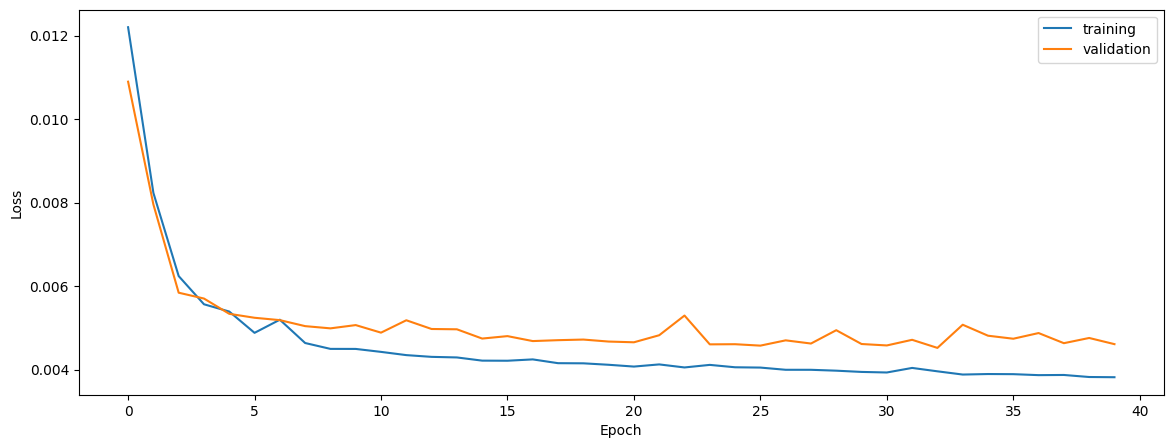

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7994342640927378
0.7770252556331443
0.7386847268988586


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.7994342640927378
0.7770252556331443
0.7386847268988586


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8113142144202261
0.797395789701741
0.7637570133716016


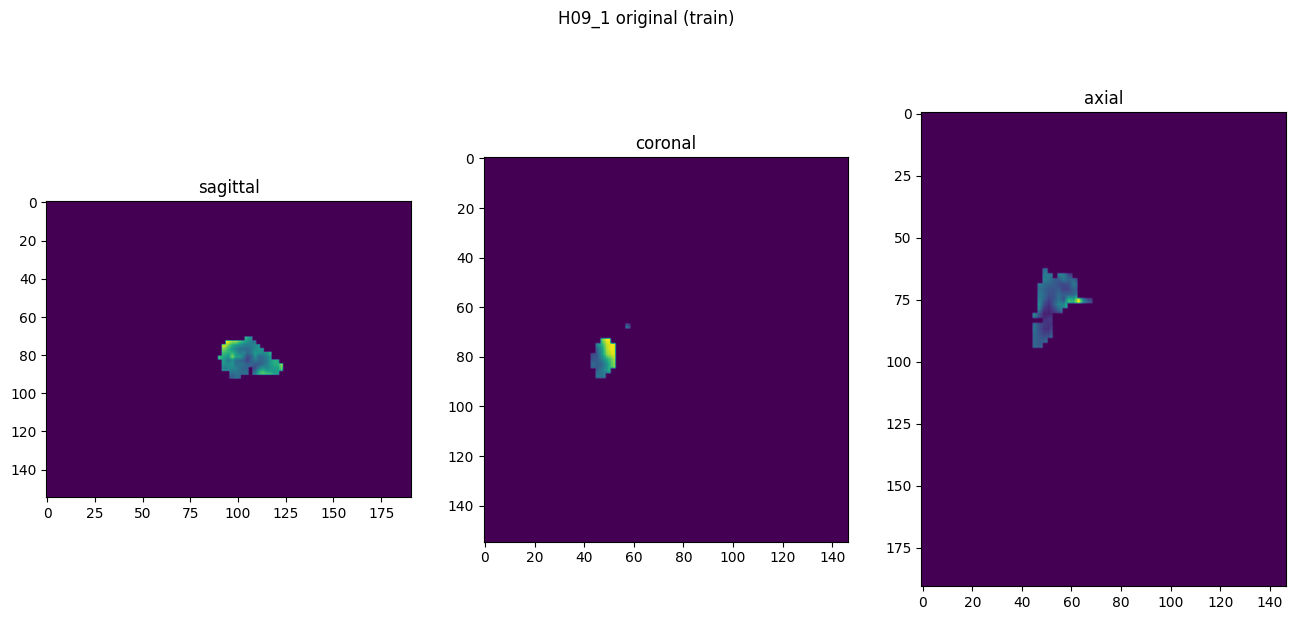

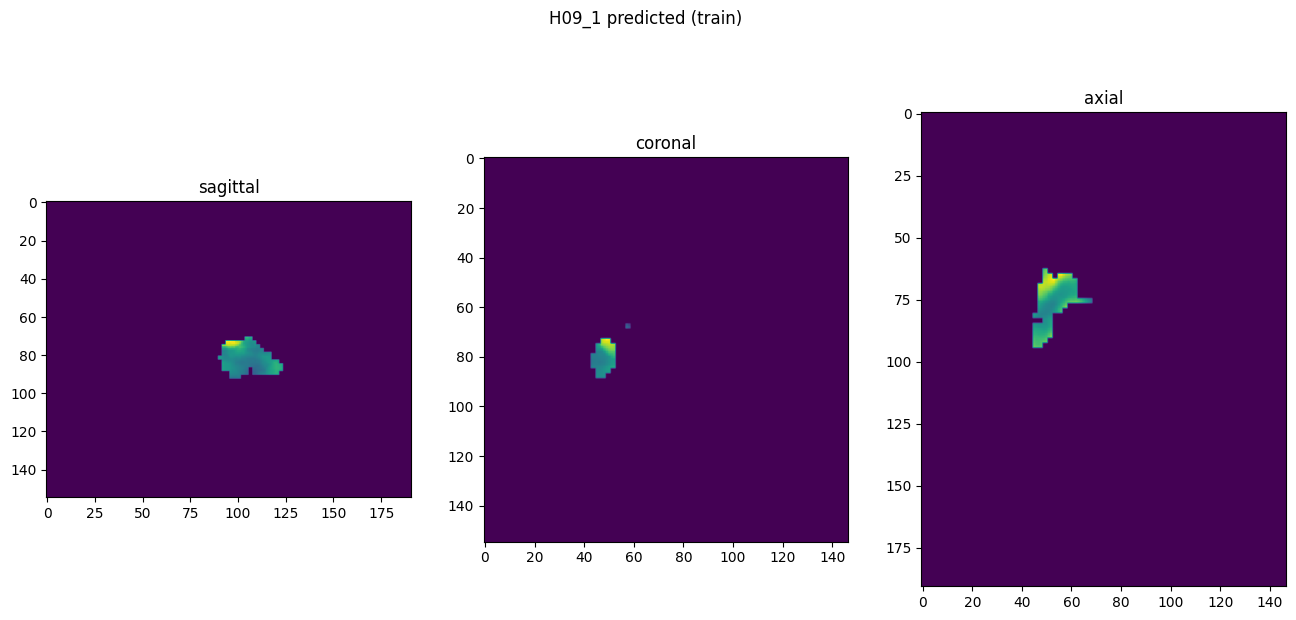

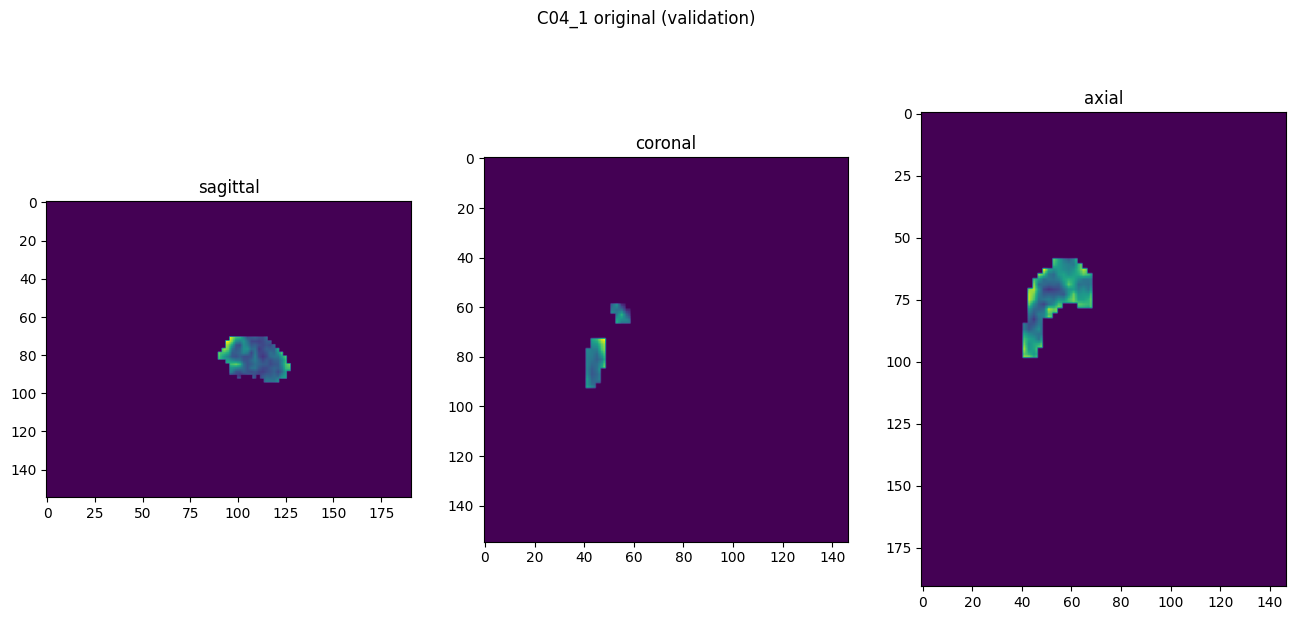

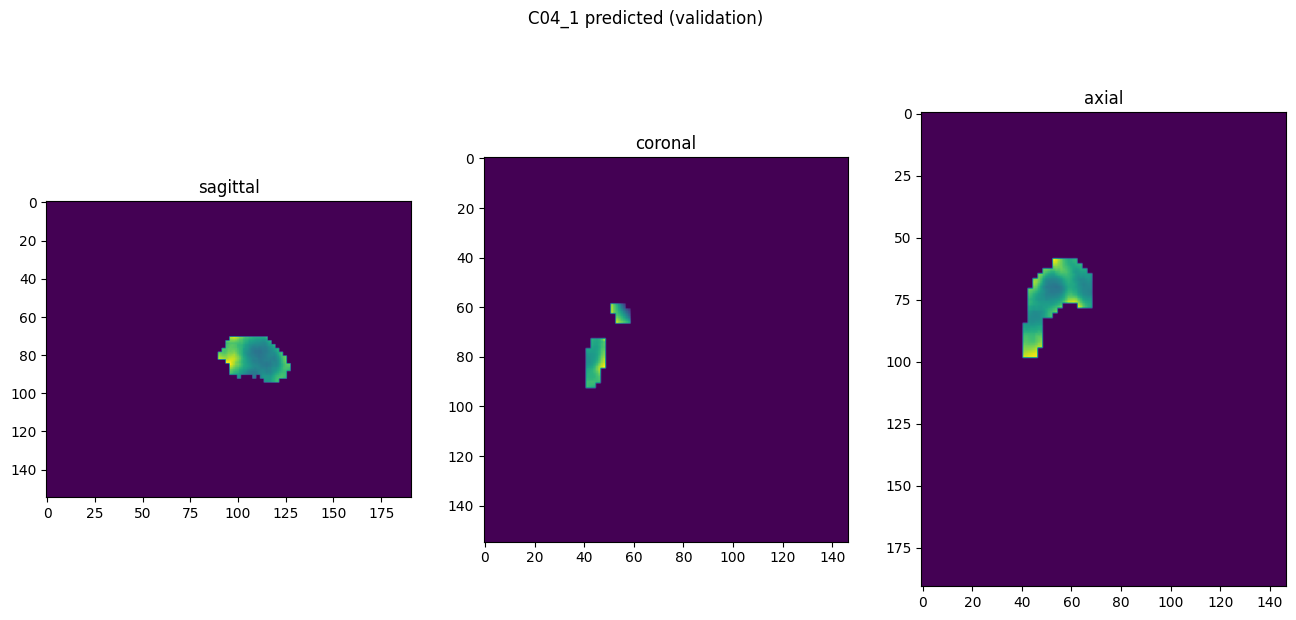

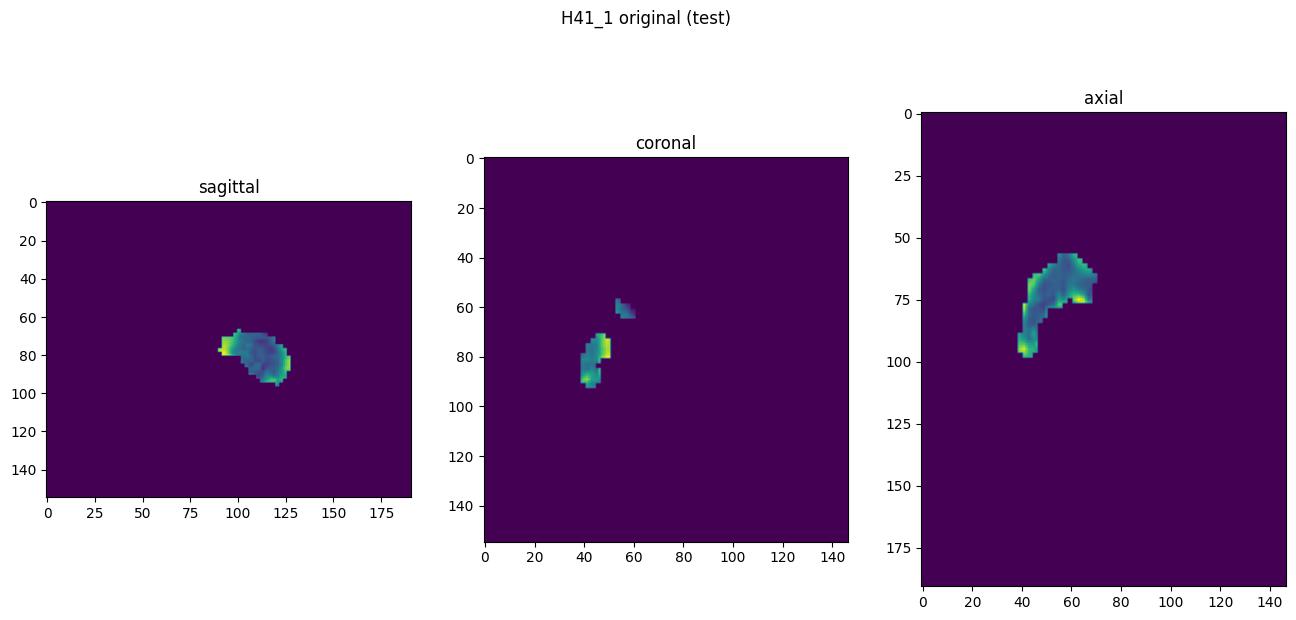

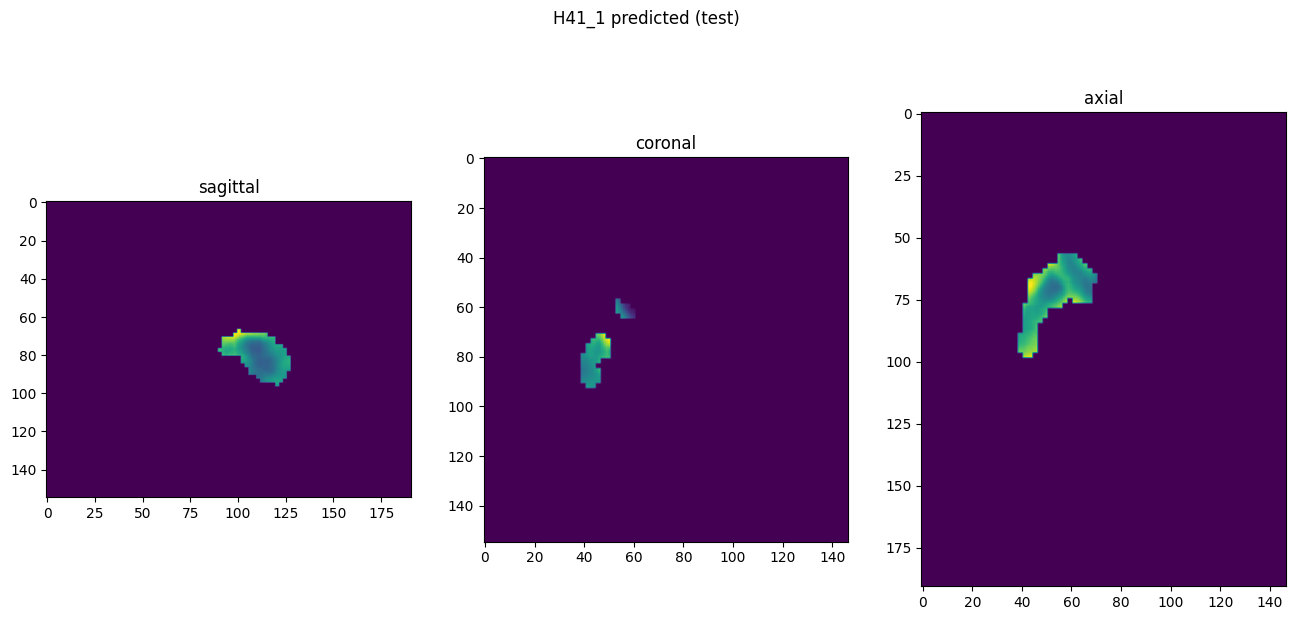

In [10]:
showResults(model, gen, threshold=None, background=False)